In [1]:
# Import the primary data analysis libraries
import matplotlib.pyplot as plt
import numpy as np 
import scipy as sp
import math
from scipy import signal
import pandas as pd
import os
import latexify
log_path = 'data/'

In [2]:
#helper function
def thresholding_algo(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))



In [3]:
#print all available files
dirs = ['Hip/', 'Pocket/Orientation1/', 'Hand/']
for folder in dirs:
    for filename in os.listdir(log_path+folder):
        print(log_path+folder+filename)

data/Hip/10Steps_L2_20210825_184100.csv
data/Hip/15Steps_L2_20210825_184003.csv
data/Hip/20Steps_L2_20210825_184146.csv
data/Pocket/Orientation1/10Steps_20210825_183129.csv
data/Pocket/Orientation1/12Steps_20210825_183207.csv
data/Pocket/Orientation1/15Steps_20210821_132340.csv
data/Pocket/Orientation1/15Steps_20210821_132752.csv
data/Pocket/Orientation1/15Steps_20210821_132926.csv
data/Pocket/Orientation1/20Steps_20210825_182900.csv
data/Pocket/Orientation1/25Steps_20210825_183002.csv
data/Pocket/Orientation1/30Steps_20210825_182748.csv
data/Hand/10Steps_L3_20210825_184434.csv
data/Hand/21Steps_L3_20210825_184240.csv
data/Hand/25Steps_L3_20210825_184329.csv


## Experiment 2
Keep phone in the same orientation but 2-3 different positions on the body

### Baseline: Windowed Peak Detection


Location = Hip
True Number of Steps = 10. Detected Number of Steps = 11
True Number of Steps = 15. Detected Number of Steps = 13
True Number of Steps = 20. Detected Number of Steps = 17
Mean Absolute Error = 2.0
Mean Percentage Error = 6.11%

Location = Pocket/Orientation1
True Number of Steps = 10. Detected Number of Steps = 10
True Number of Steps = 12. Detected Number of Steps = 13
True Number of Steps = 15. Detected Number of Steps = 16
True Number of Steps = 15. Detected Number of Steps = 16
True Number of Steps = 15. Detected Number of Steps = 16
True Number of Steps = 20. Detected Number of Steps = 21
True Number of Steps = 25. Detected Number of Steps = 25
True Number of Steps = 30. Detected Number of Steps = 26
Mean Absolute Error = 3.0
Mean Percentage Error = 6.67%

Location = Hand
True Number of Steps = 10. Detected Number of Steps = 3
True Number of Steps = 21. Detected Number of Steps = 11
True Number of Steps = 25. Detected Number of Steps = 13
Mean Absolute Error = 9.66

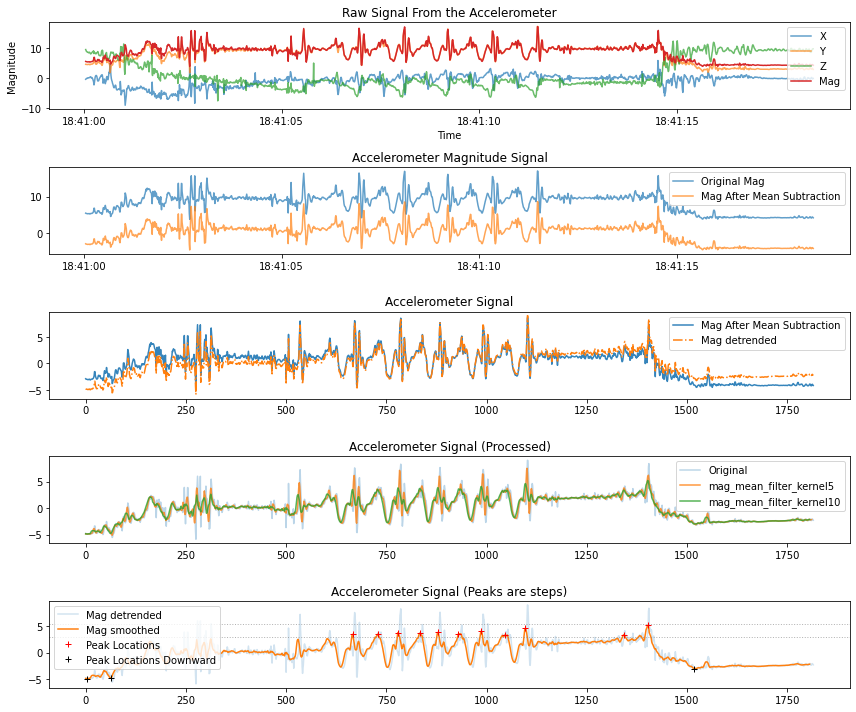

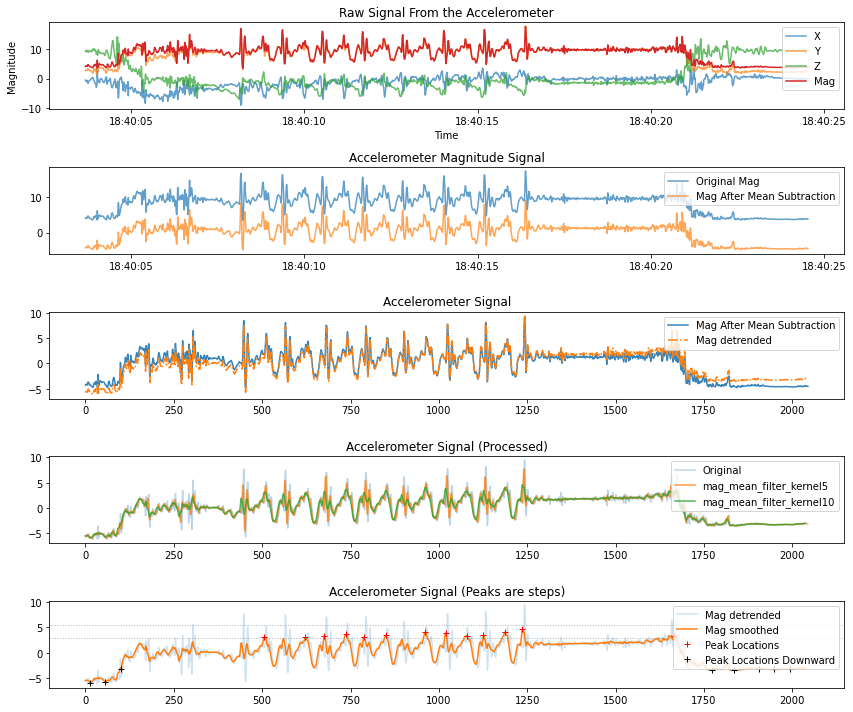

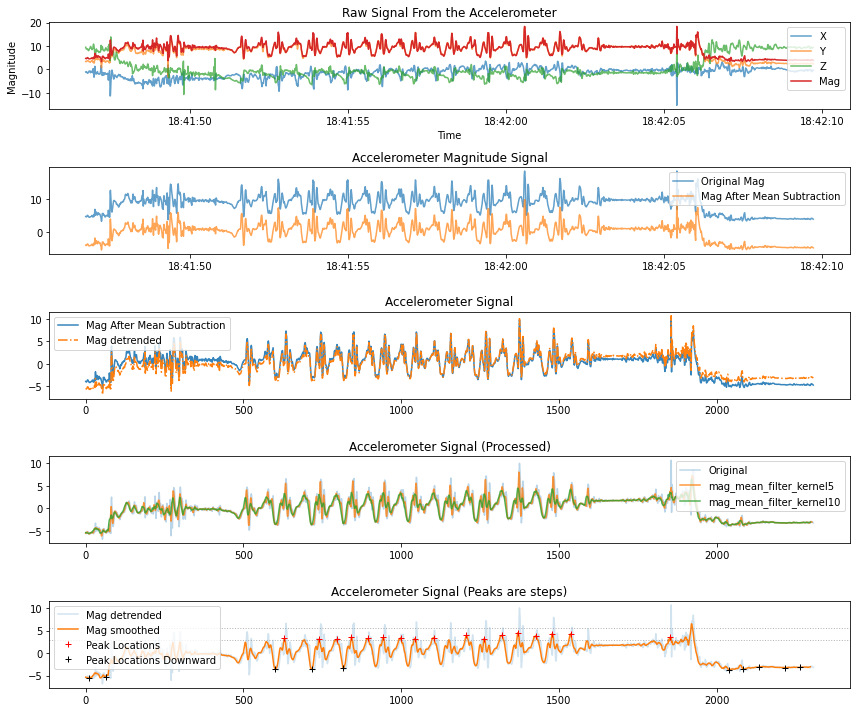

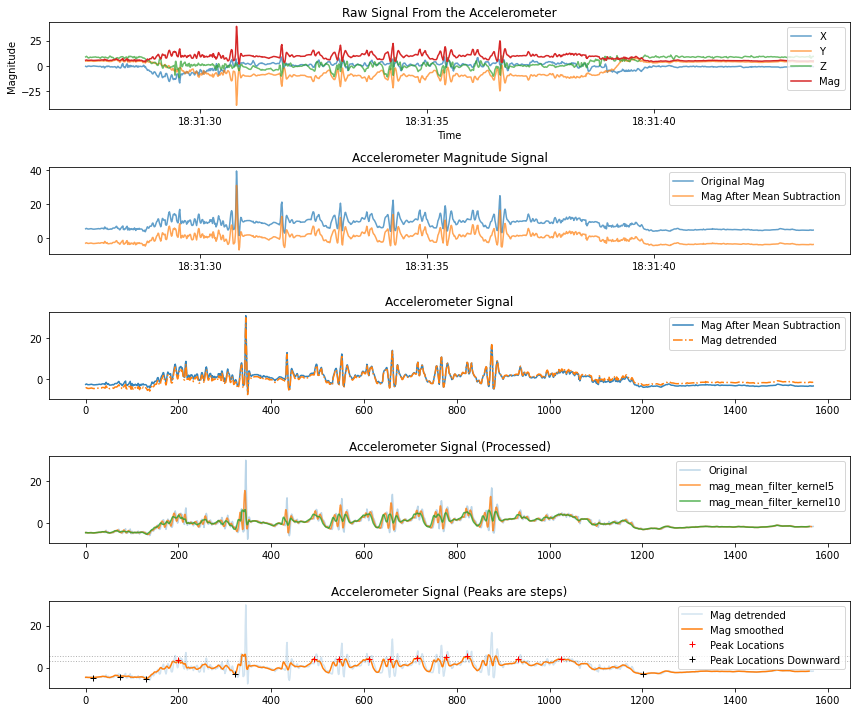

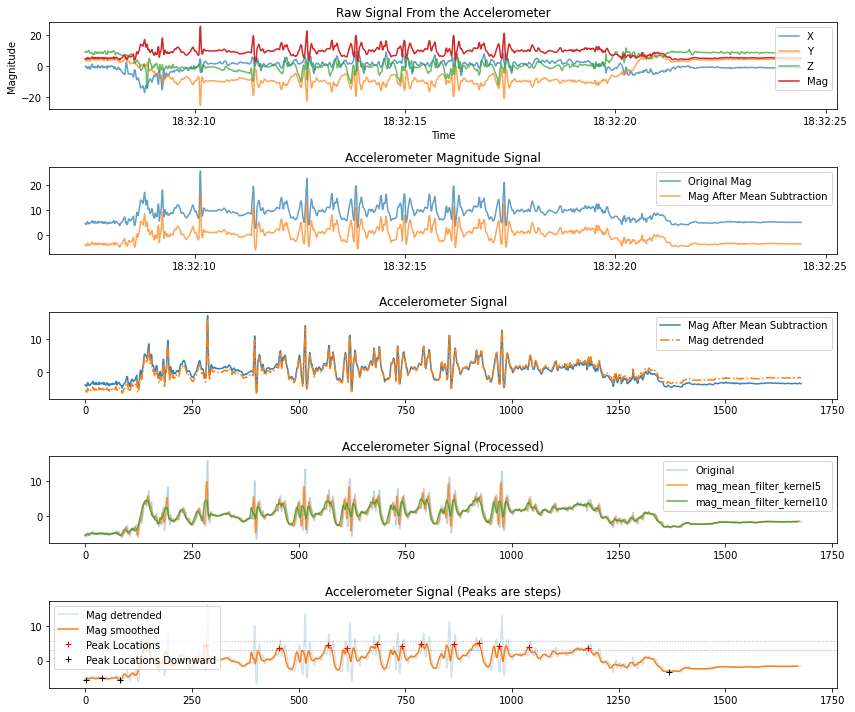

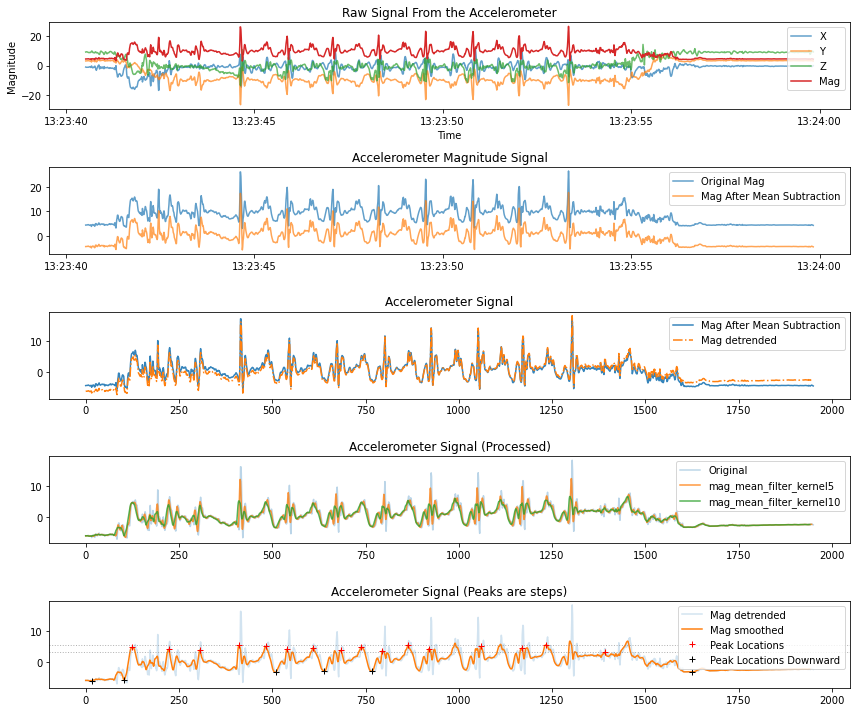

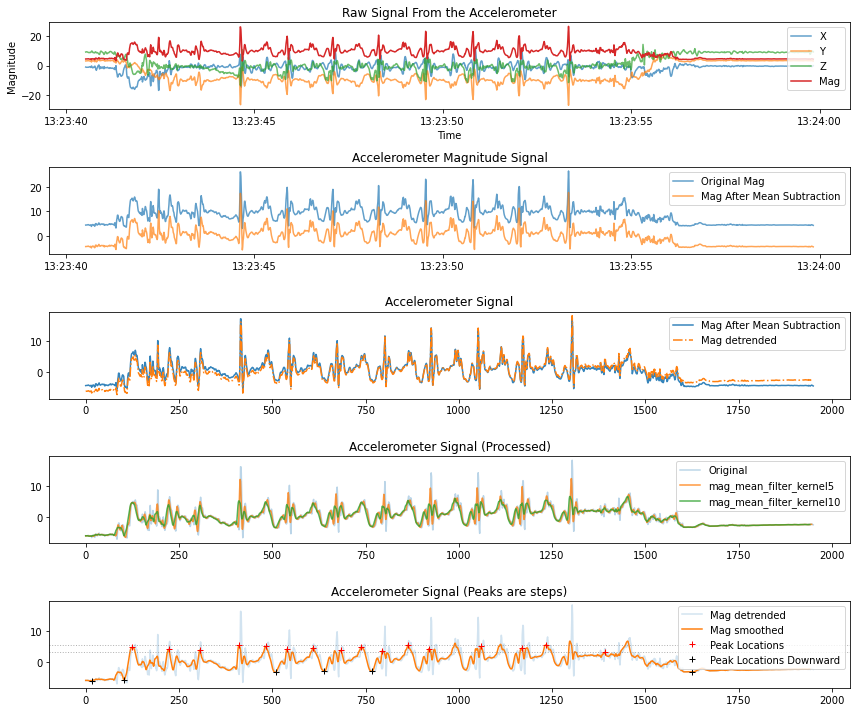

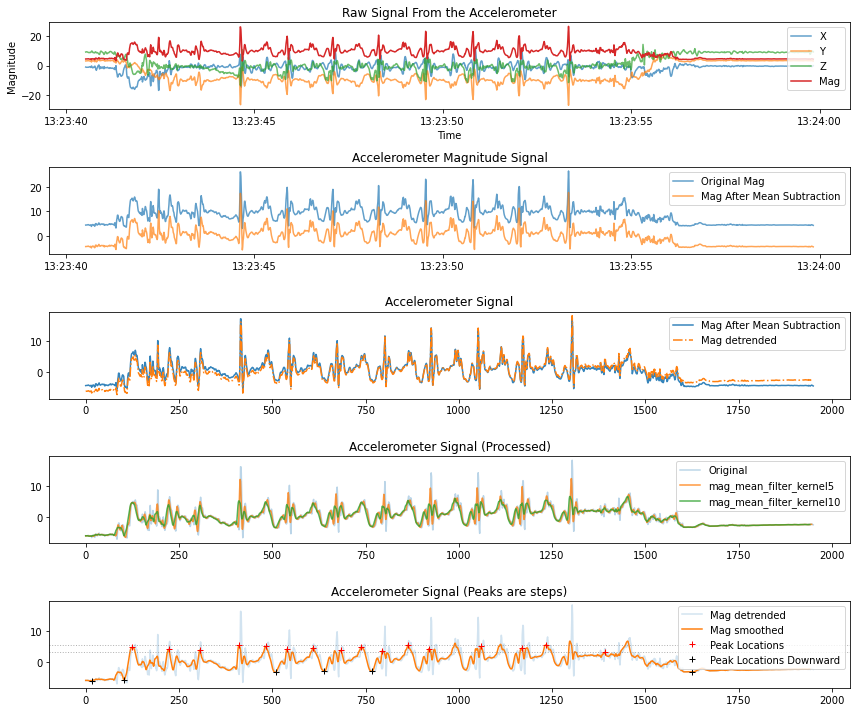

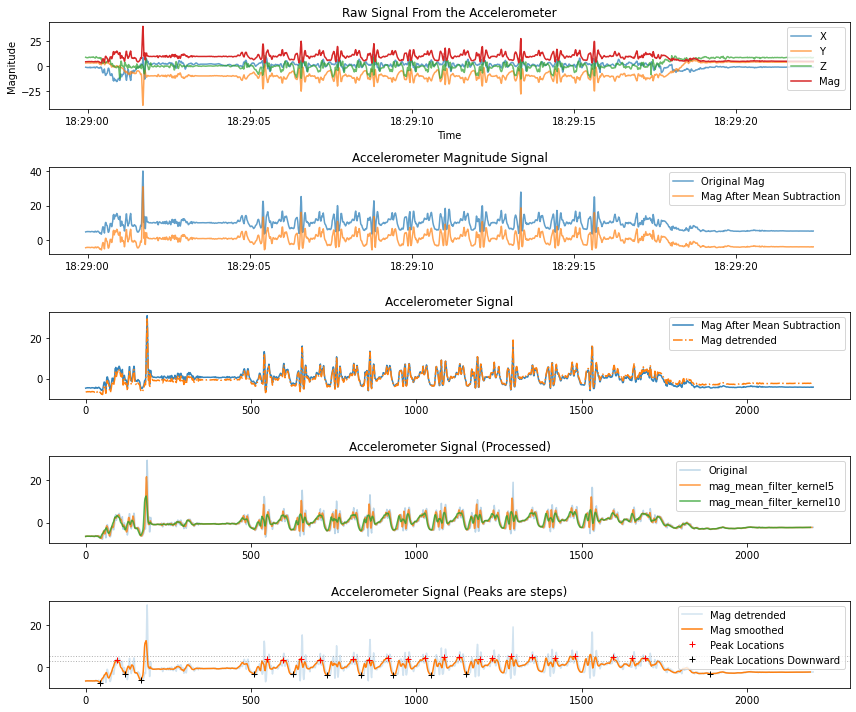

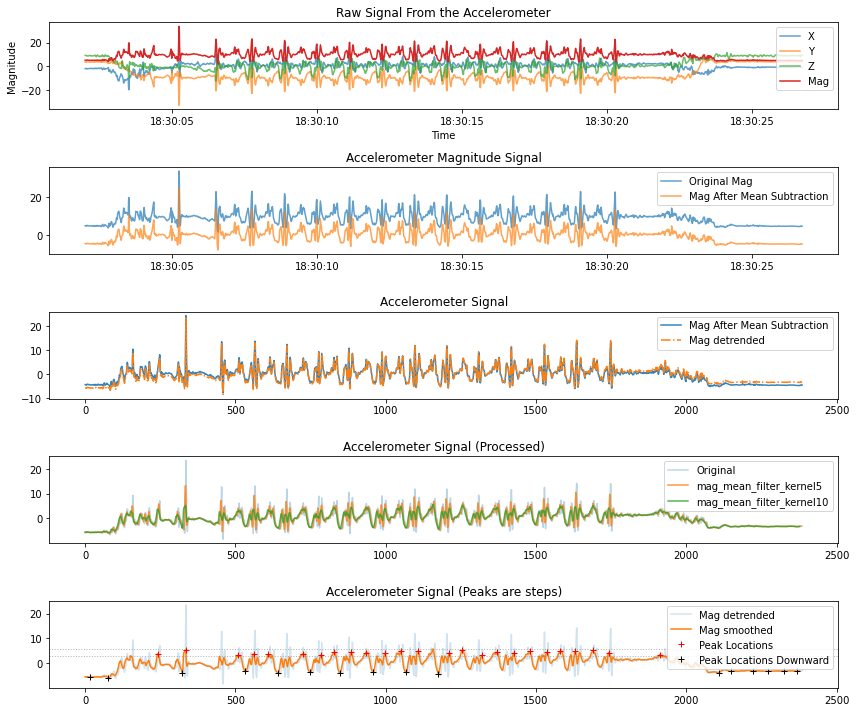

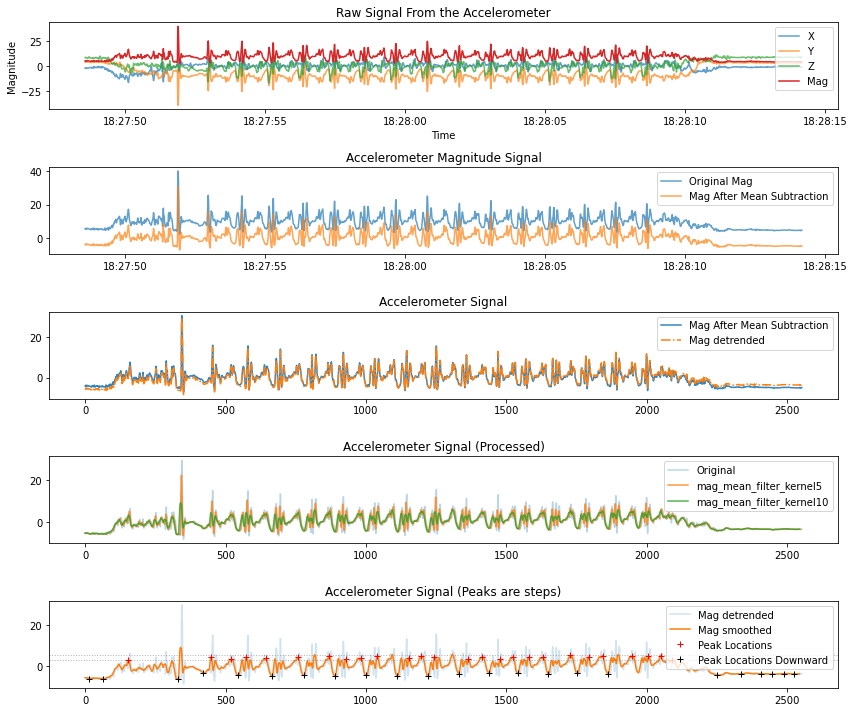

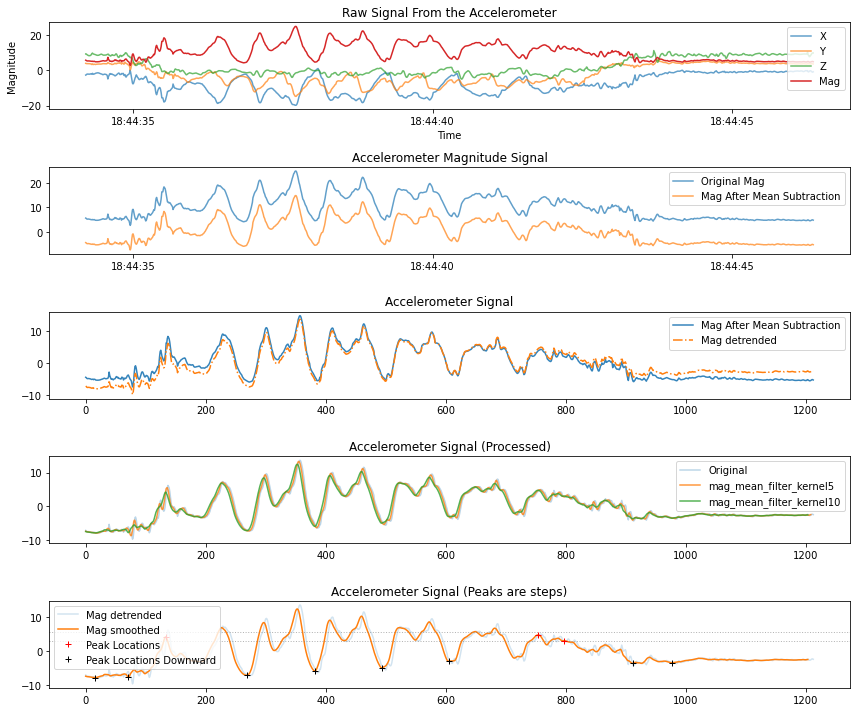

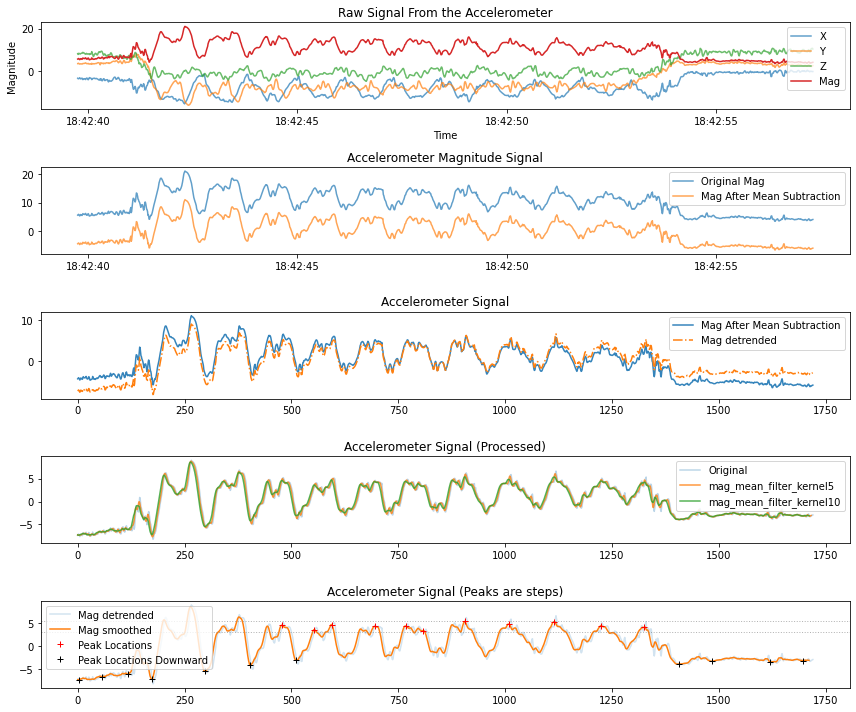

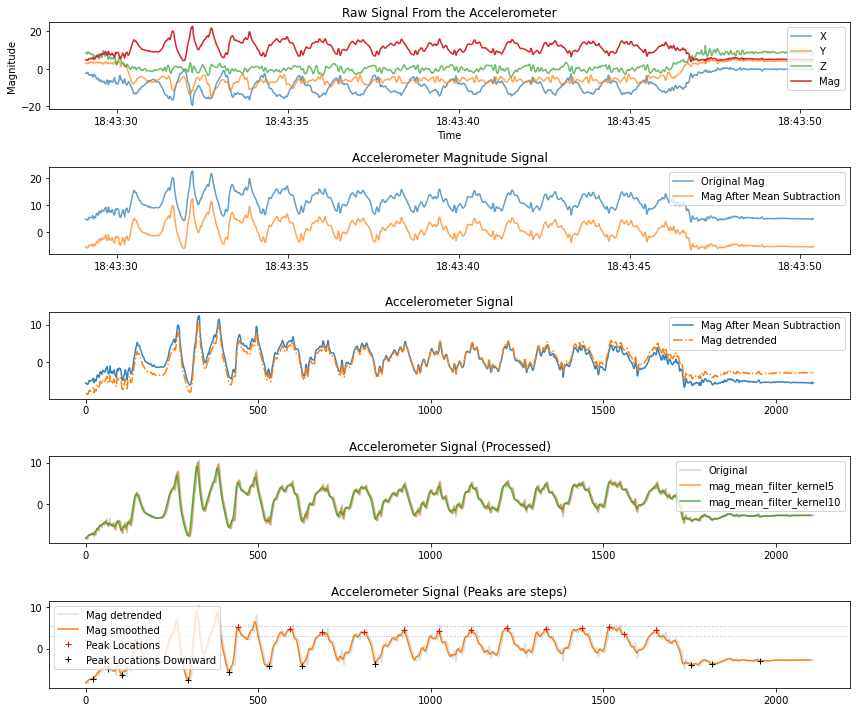

In [4]:
detailedOutput = False;

#lists to generate bar plot
positions = []
mperrors = []

for folder in dirs:
    difference = 0 #this variable will be used to track the Mean Absolute Error.
    mpe = 0 #this variable will track the mean percentage error
    print("\nLocation = {}".format(folder[:-1]))
    positions.append(folder[:-1])
    for filename in os.listdir(log_path+folder):
        #each file contains the step count in the first two characters
        groundTruth = int(filename[:2])
        df1 = pd.read_csv(log_path+folder+filename).dropna()
        df1['Timestamp'] = pd.to_datetime(df1.Timestamp, format='%d-%b-%Y %H:%M:%S.%f')
        df1.index = df1.Timestamp;

        fig, ax = plt.subplots(5,1, figsize=(12,10))
        ax[0].plot(df1.Timestamp, df1.X, alpha=0.7)
        ax[0].plot(df1.Timestamp, df1.Y, alpha=0.7)
        ax[0].plot(df1.Timestamp, df1.Z, alpha=0.7)
        ax[0].plot(df1.Timestamp, np.sqrt(df1.X**2+df1.Y**2+df1.Z))
        ax[0].set_title('Raw Signal From the Accelerometer')
        ax[0].legend(['X', 'Y', 'Z', 'Mag'])
        ax[0].set_xlabel('Time')
        ax[0].set_ylabel('Magnitude')


        acc1_mag = np.sqrt(df1.X**2+df1.Y**2+df1.Z)
        if detailedOutput == True:
            print("**Statistics of the accelerometer signal**")
        sample_time_in_s = df1.Timestamp.iloc[-1] - df1.Timestamp.iloc[0]
        if detailedOutput == True:
            print("Length (raw diff): {} secs".format(sample_time_in_s.seconds))
            print("Avg x: {:.2f} (SD={:.2f})".format(np.mean(df1.X), np.std(df1.X)))
            print("Avg y: {:.2f} (SD={:.2f})".format(np.mean(df1.Y), np.std(df1.Y)))
            print("Avg z: {:.2f} (SD={:.2f})".format(np.mean(df1.Z), np.std(df1.Z)))
            print("Avg mag: {:.2f} (SD={:.2f})\n".format(np.mean(acc1_mag), np.std(acc1_mag)))
        #Derive sampling rate for TYPE 1
        map_sec_to_sample_count = dict()
        for timestamp_ms in df1.Timestamp:
            sec_floor = timestamp_ms.second
            if sec_floor not in map_sec_to_sample_count:
                map_sec_to_sample_count[sec_floor] = 0
            map_sec_to_sample_count[sec_floor] = map_sec_to_sample_count[sec_floor] + 1

        if detailedOutput == True:
            print("Length (raw diff): {} secs".format(sample_time_in_s.seconds))
            print("Length (rounded ceiling): {} secs".format(len(map_sec_to_sample_count)))
        counts = list(map_sec_to_sample_count.values())
        np_counts = np.array(counts)
        sampling_rate_imprecise = df1.Timestamp.size / sample_time_in_s.seconds
        if detailedOutput == True:
            print("Coarse sampling rate: {:.2f} samples/sec".format(sampling_rate_imprecise))
        sampling_rate = np.average(np_counts)
        if detailedOutput == True:
            print("Coarse sampling rate: {:.2f} samples/sec".format(sampling_rate_imprecise))
            print("More precise sampling rate calc: {:.2f} samples/sec (SD={:.2f} samples/sec)".format(sampling_rate, np.std(np_counts)))

        #Here, we'll subtract out the mean so that the average of the signal is 0
        #useful to count ZCR
        mag_after_mean_subtraction = acc1_mag - np.average(acc1_mag)
        if detailedOutput == True:
            print("Average of the signal [Before] = {}".format(np.average(acc1_mag)))
            print("Average of the signal [After] = {}".format(np.average(mag_after_mean_subtraction)))
        ax[1].plot(acc1_mag, alpha=0.7, label="Original Mag")
        ax[1].plot(mag_after_mean_subtraction, alpha=0.7, label="Mag After Mean Subtraction")
        ax[1].set_title("Accelerometer Magnitude Signal")
        ax[1].legend();

        # We can also use scipy's built in detrend algorithm, which is the result
        # of a linear least-squares fit to the data
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.detrend.html
        mag_detrended = sp.signal.detrend(acc1_mag) 
        ax[2].plot(mag_after_mean_subtraction.values, alpha=0.9, label="Mag After Mean Subtraction")
        ax[2].plot(mag_detrended, alpha=1, linestyle="-.", label="Mag detrended")
        ax[2].set_title("Accelerometer Signal")
        ax[2].legend()

        # Here are different mean smoothing filters
        # Note that the filter window size should really be a function of your sampling rate
        # Now, let's play around with various smoothing methods
        # Here are different mean smoothing filters
        # Note that the filter window size should really be a function of your sampling rate
        filter_window_size = 5
        # Convolve using a mean filter
        # https://numpy.org/doc/stable/reference/generated/numpy.convolve.html?highlight=convolve#numpy.convolve
        mag_mean_filter_kernel5 = np.convolve(mag_detrended, np.ones((filter_window_size,))/filter_window_size, mode='valid')
        filter_window_size = 10
        mag_mean_filter_kernel10 = np.convolve(mag_detrended, np.ones((filter_window_size,))/filter_window_size, mode='valid')
        ax[3].plot(mag_detrended, alpha=0.3, label="Original")
        ax[3].plot(mag_mean_filter_kernel5, alpha=0.8, label="mag_mean_filter_kernel5")
        ax[3].plot(mag_mean_filter_kernel10, alpha=0.8, label="mag_mean_filter_kernel10")
        ax[3].set_title("Accelerometer Signal (Processed)")
        ax[3].legend()



        # Now, basic algorithm to infer steps
        filter_window_size = math.ceil(sampling_rate * 0.1)

        # Convolve using a mean filter
        # https://numpy.org/doc/stable/reference/generated/numpy.convolve.html?highlight=convolve#numpy.convolve
        mag_filtered = np.convolve(mag_detrended, np.ones((filter_window_size,))/filter_window_size, mode='valid')
        ax[4].plot(mag_detrended, alpha=0.2, label="Mag detrended")
        ax[4].plot(mag_filtered, alpha=1, label="Mag smoothed")
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html
        # assume stride cadence threshold of ~100 steps/min, which is 1.6 steps/sec
        # but let's round it up to ~2 steps/sec (so, 2 Hz)
        # so, once we find a peak, we should wait ~0.5 seconds, which we translate into num of samples
        min_distance_between_peaks = 0.4 * sampling_rate # distance between peaks in samples
        min_peak_height = 3
        max_peak_height = 5.5


        peak_indices, peak_properties = sp.signal.find_peaks(mag_filtered, height=min_peak_height, distance=min_distance_between_peaks)
        peak_indices_i, peak_properties_i = sp.signal.find_peaks(-mag_filtered, height=min_peak_height, distance=min_distance_between_peaks)

        if detailedOutput == True:
            print("Min num samples between peaks:", min_distance_between_peaks)
            print("We've detected:", len(peak_indices), "initial peaks")
            print("Average peak:", np.average(mag_filtered[peak_indices]), "SD=", np.std(mag_filtered[peak_indices]))
            print("Min peak:", np.min(mag_filtered[peak_indices]))
            print("Max peak:", np.max(mag_filtered[peak_indices]))
            print();
            print("We've detected:", len(peak_indices_i), "initial peaks in the inverted signal")
            print("Average peak:", np.average(mag_filtered[peak_indices_i]), "SD=", np.std(mag_filtered[peak_indices_i]))
            print("Min peak:", np.min(mag_filtered[peak_indices_i]))
            print("Max peak:", np.max(mag_filtered[peak_indices_i]))
            print("Filtering out peaks that exceed our maximum:")

        # filter out peaks that exceed our maximum
        filtered_peak_indices = []
        for peak_index in peak_indices:
            if(mag_filtered[peak_index] <= max_peak_height):
                filtered_peak_indices.append(peak_index)

        filtered_peak_indices_i = []
        for peak_index in peak_indices_i:
            if(mag_filtered[peak_index] <= max_peak_height):
                filtered_peak_indices_i.append(peak_index)

        peak_indices = list(filtered_peak_indices)
        peak_indices_i = list(filtered_peak_indices_i)

        if detailedOutput == True:
            print("***Now, we've detected:", len(peak_indices), " peaks***")
            print("Average peak:", np.average(mag_filtered[peak_indices]), "SD=", np.std(mag_filtered[peak_indices]))
            print("Min peak:", np.min(mag_filtered[peak_indices]))
            print("Max peak:", np.max(mag_filtered[peak_indices]))
            print("Now, we've detected:", len(peak_indices_i), " peaks")
            print("Average peak:", np.average(mag_filtered[peak_indices_i]), "SD=", np.std(mag_filtered[peak_indices_i]))
            print("Min peak:", np.min(mag_filtered[peak_indices_i]))
            print("Max peak:", np.max(mag_filtered[peak_indices_i]))

        # Plots the peaks
        ax[4].axhline(y=min_peak_height, linewidth=1, linestyle=":", alpha=0.6, color='gray')
        ax[4].axhline(y=max_peak_height, linewidth=1, linestyle=":", alpha=0.6, color='gray')
        ax[4].plot(peak_indices, mag_filtered[peak_indices], 'y+', color="red", label="Peak Locations")
        ax[4].plot(peak_indices_i, mag_filtered[peak_indices_i], 'y+', color="black", label="Peak Locations Downward")

        ax[4].set_title("Accelerometer Signal (Peaks are steps)")
        ax[4].legend()
        fig.tight_layout()
        print("True Number of Steps = {}. Detected Number of Steps = {}".format(groundTruth,len(peak_indices)))
        #compute error
        difference+=(abs(groundTruth-len(peak_indices)))
        mpe+=((groundTruth-len(peak_indices))/groundTruth)
    print("Mean Absolute Error = {}".format(difference/len(os.listdir(log_path))))
    mpe = abs((mpe/len((os.listdir(log_path)))*100));
    print("Mean Percentage Error = {:.2f}%".format(mpe))
    mperrors.append(mpe)



### Modified Peak Detection Algorithm
Note that the `threshold` was empirically chosen for different position of the body. The low frequency noise gets eliminated by taking the average of 10 data points of the signal


Location = Hip

Steps Detected = 13
Ground Truth = 10

Steps Detected = 18
Ground Truth = 15

Steps Detected = 13
Ground Truth = 20
Mean Percentage Error = 5.00%

Location = Pocket/Orientation1

Steps Detected = 15
Ground Truth = 10

Steps Detected = 12
Ground Truth = 12

Steps Detected = 13
Ground Truth = 15

Steps Detected = 13
Ground Truth = 15

Steps Detected = 13
Ground Truth = 15

Steps Detected = 21
Ground Truth = 20

Steps Detected = 26
Ground Truth = 25

Steps Detected = 26
Ground Truth = 30
Mean Percentage Error = 1.89%

Location = Hand

Steps Detected = 14
Ground Truth = 10

Steps Detected = 21
Ground Truth = 21

Steps Detected = 17
Ground Truth = 25
Mean Percentage Error = 2.67%


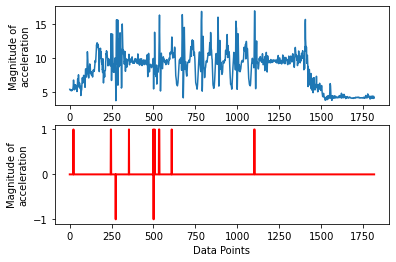

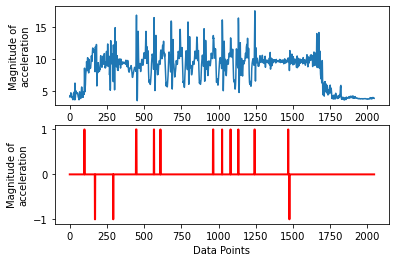

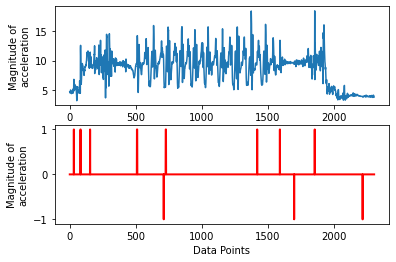

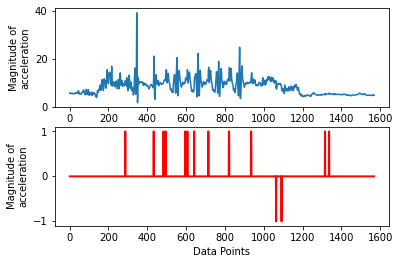

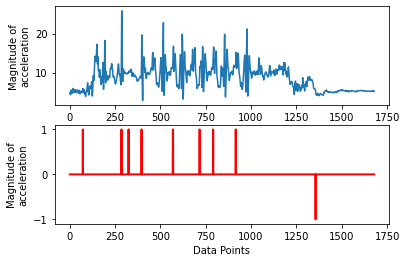

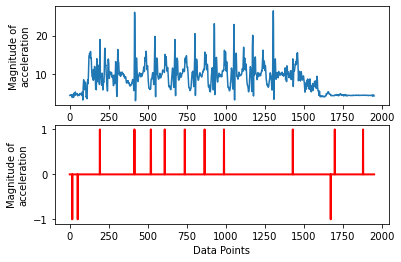

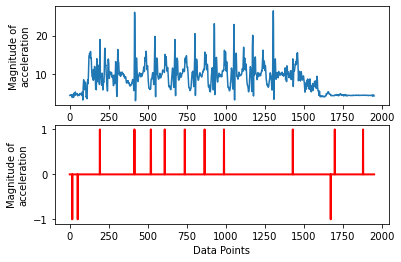

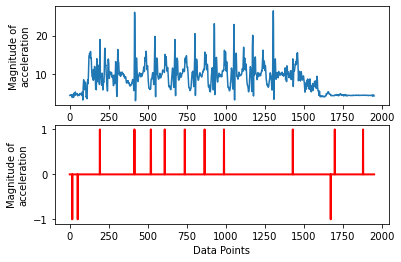

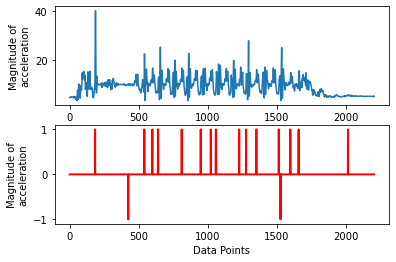

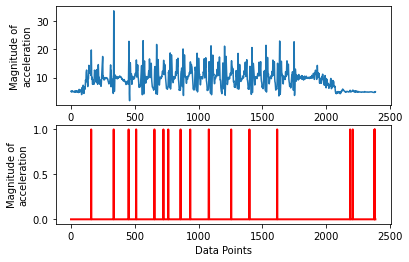

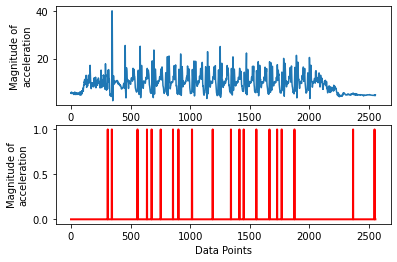

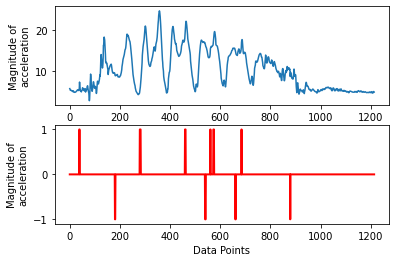

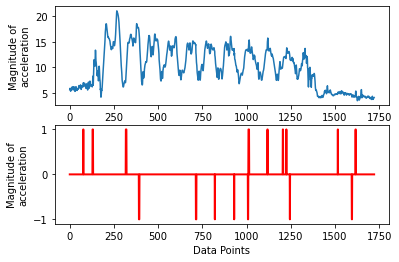

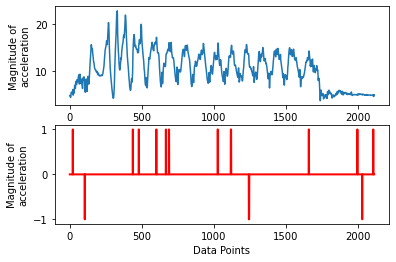

In [5]:
mpe=0;

#lists to generate bar plot
positions_2 = []
mperrors_2 = []


#use optimal values detected above
for folder in dirs:
    difference = 0 #this variable will be used to track the Mean Absolute Error.
    mpe = 0 #this variable will track the mean percentage error
    print("\nLocation = {}".format(folder[:-1]))
    positions_2.append(folder[:-1])
    for filename in os.listdir(log_path+folder):
        fig, ax  = plt.subplots(2,1)
        #each file contains the step count in the first two characters
        groundTruth = int(filename[:2])
        df1 = pd.read_csv(log_path+folder+filename).dropna()
        df1['Timestamp'] = pd.to_datetime(df1.Timestamp, format='%d-%b-%Y %H:%M:%S.%f')
        df1.index = df1.Timestamp;
        acc1_mag = np.sqrt(df1.X**2+df1.Y**2+df1.Z)
        # Run algo with settings from above
        
        if folder[:-1] == 'Pocket/Orientation1':
            result = thresholding_algo(acc1_mag, lag=10, threshold=6, influence=0.8)
        elif folder[:-1] == 'Hip':
            result = thresholding_algo(acc1_mag, lag=10, threshold=6, influence=0.4)
        elif folder[:-1] == 'Hand':
            result = thresholding_algo(acc1_mag, lag=10, threshold=5, influence=0.4)

        ax[0].plot(np.arange(1, len(acc1_mag)+1), acc1_mag)
        ax[0].set_xlabel("Data Points")
        ax[0].set_ylabel("Magnitude of\nacceleration")
        #ax[0].plot(np.arange(1, len(acc1_mag)+1),result["avgFilter"], color="cyan", lw=2)
        #ax[0].plot(np.arange(1, len(acc1_mag)+1),result["avgFilter"] + threshold * result["stdFilter"], color="green", lw=2)
        #ax[0].plot(np.arange(1, len(acc1_mag)+1),result["avgFilter"] - threshold * result["stdFilter"], color="green", lw=2)
        ax[1].plot(np.arange(1, len(acc1_mag)+1), result["signals"], color="red", lw=2)
        ax[1].set_xlabel("Data Points")
        ax[1].set_ylabel("Magnitude of\nacceleration")
        print("\nSteps Detected = {}".format(len([i for i in result["signals"] if i == 1.0])))
        print("Ground Truth = {}".format(groundTruth))
        mpe+=((groundTruth-len([i for i in result["signals"] if i == 1.0]))/groundTruth)

    mpe = abs((mpe/len((os.listdir(log_path)))*100));
    print("Mean Percentage Error = {:.2f}%".format(mpe))
    mperrors_2.append(mpe)

### Report Error

C:\ProgramData\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


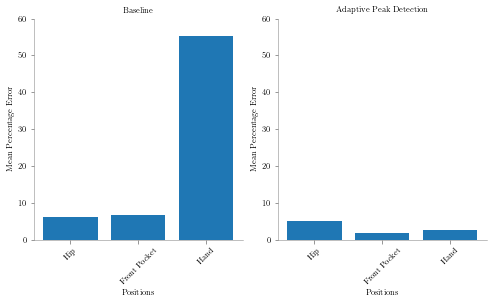

In [6]:
latexify.latexify(columns=2)
fig, ax = plt.subplots(1,2);
ax[0].bar(positions, mperrors, width = 0.8)
ax[0].set_xlabel("Positions")
ax[0].set_ylabel("Mean Percentage Error")
ax[0].set_ylim([0,60])
ax[0].set_xticklabels(['Hip', 'Front Pocket', 'Hand'], rotation = 45)
ax[0].set_title('Baseline')
latexify.format_axes(ax[0])

ax[1].bar(positions_2, mperrors_2, width = 0.8)
ax[1].set_xlabel("Positions")
ax[1].set_ylabel("Mean Percentage Error")
ax[1].set_ylim([0,60])
ax[1].set_xticklabels(['Hip', 'Front Pocket', 'Hand'], rotation = 45)
ax[1].set_title('Adaptive Peak Detection')
latexify.format_axes(ax[1])
fig.tight_layout()
plt.savefig("location-result.pdf", bbox_inches='tight')